# Problem Set 3, due May 8 at 3:30 pm

### Before You Start

Make sure the following libraries load correctly.  Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

*Also note:* please use base **matplotlib** - not Seaborn or other packages. This will help you become familiar with techniques for maintaining fine-grained control over your data visualizations. It will also help our graders, who spent countless hours trying to make various versions import for grading.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt  
%matplotlib inline  


---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()
print (bdata.data.shape)
print (bdata.DESCR)

(506, 13)
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by t

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, familiarize yourself with the
dataset.  Analyze basic summary of the variables, plot histogram of
house price values, etc.

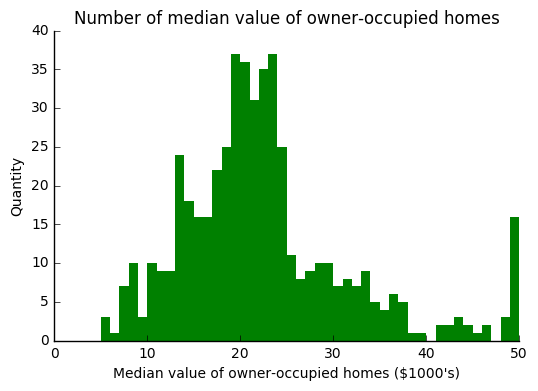

In [3]:
boston = pd.DataFrame(bdata.data, columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
boston["MEDV"] = bdata.target
boston
boston.describe()

hist = plt.hist(bdata.target, color = 'green', edgecolor = "none", bins=np.arange(0, max(bdata.target) + 1, 1))

plt.xlabel("Median value of owner-occupied homes ($1000's)")
plt.ylabel('Quantity')
plt.title('Number of median value of owner-occupied homes')

ax = plt.subplot()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### 1.1: Scatter plot of housing prices and crime

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional. No excuses if you don't get it right this time around!


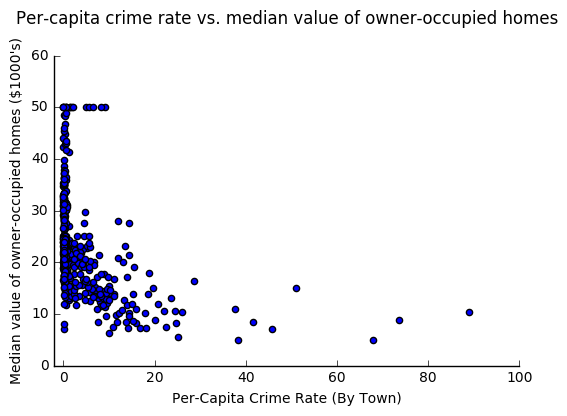

In [4]:
plt.scatter(boston.CRIM, boston.MEDV)
plt.xlabel("Per-Capita Crime Rate (By Town)")
plt.ylabel("Median value of owner-occupied homes ($1000's)")
plt.title("Per-capita crime rate vs. median value of owner-occupied homes", y=1.08)
plt.xlim(xmin=-2)

ax = plt.subplot()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### 1.2 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. 
Details of RMSE can be found in Hastie, Tibishrani, Friedman _The
Elements of Statistical Learning_, Ch 2.5. (Available on the web)


In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def compute_rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse


### 1.3 Divide your data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset
(call this "bdata_train"), and place the remaining 34% in a testing
dataset (call this "bdata_test").  Please us 'np.random' for random numbers.


In [6]:
# Please use this seed, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

boston_df = boston
randomize = np.random.rand(len(boston_df)) < 0.66
bdata_train = boston_df[randomize]
bdata_test = boston_df[~randomize]
bdata_test = bdata_test.reset_index(drop=True)
bdata_train = bdata_train.reset_index(drop=True)


### 1.4 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set.  Now compute the RMSE on the test data set (but use the model you trained on the training set!).  How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

In [7]:
#baseline model - average value of mhv on training data
mean_trn = [np.mean(bdata_train['MEDV'])] * len(bdata_train)                 
print ("RMSE: ", compute_rmse(mean_trn, bdata_train['MEDV'].values))
    
#RMSE for test set
mean_tst = [np.mean(bdata_test['MEDV'])] * len(bdata_test)
print ("RMSE: ", compute_rmse(mean_tst, bdata_test['MEDV'].values))


RMSE:  8.8520272761929
RMSE:  9.631800440542408


The RMSE for the test dataset was higher by about 0.78. This is what I expected because since the model was made with the training data, exposure to training data could make less error compared to being applied to the test dataset.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average
Value" baseline that you computed above.  Soon you will implement the
Nearest Neighbor algorithm, but first you need to create a distance
metric to measure the distance (and similarity) between two instances.
Write a generic function to compute the Lp-Norm distance. Verify that
your function works by computing the L-2 (Euclidean) distance and L-1 (Manhattan) distance between the points (3,4) and (6,8), and between (6,8) and (3,4).  Ensure that your distance is correct and positive in both cases!

In [8]:
# guidance from here: http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

import math

def distance(x1, x2, L):
    dist = abs(np.sum((np.array(x1) - np.array(x2)) ** L)) ** (1 / L)
    return dist

print(distance((3,4),(6,8), 1))
print(distance((3,4),(6,8), 2))


7.0
5.0


### 2.2 Basic Nearest Neighbor algorithm

Now things get fun.  Your task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as
you know, with Nearest Neighbors there is no real training, you just
need to keep your training data in memory.  Write a function that
predicts, for each instance in the testing data (bdata_test), the
median home value using the nearest neighbor algorithm we discussed in
class.  Since this is a small dataset, you can simply compare your
test instance to every instance in the training set, and return the
MEDV value of the closest training instance.  You can just loop over
the instances to find the nearest neighbor.  Have your function take L as an input, where L is passed to the distance function.

Compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

Plot the true vs predicted price for your test data

In [11]:
import time
input_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

def nneighbor(train, test, input_features, L):
    start_time = time.time()

    predictions = []
    
    for i in range(len(test)):
        min_distance = 99999
        curr_prediction = 0
        for j in range(len(train)):
            curr_dist = distance(test[input_features].loc[i], train[input_features].loc[j], L)
            if curr_dist < min_distance:
                min_distance = curr_dist
                curr_prediction = train['MEDV'][j]
        predictions.append(curr_prediction)
    
    print ("Time estimate: " + str(round(time.time() - start_time, 2)) + " seconds")

    rmse = compute_rmse(predictions, test["MEDV"])
#     plt.scatter(predictions, bdata_test["MEDV"])  
    return rmse

nneighbor(bdata_train, bdata_test, ["RM", "CRIM"], 2)




Time estimate: 68.4 seconds


5.736824193964875

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Normalization is similar to Mahalanobis disctance (if the features are independent).  Read more in Daume (2017), _A Course in Machine Learning_ Chapter 4.3.  Write a simple generic normalization function that takes as input an array of values for a given feature, and returns the normalized array.  Do it well, you will need it in the future as well ;-)

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [12]:
def normalize(dataset):
    avg = dataset.mean()
    standard_deviation = np.std(dataset)

    normal = []    

    for i in dataset:  
        norm = (i - avg) / standard_deviation
        normal.append(norm)
    return normal

bdata_train['CRIM'] = normalize(bdata_train['CRIM'])
bdata_train['RM'] = normalize(bdata_train['RM'])
bdata_train['MEDV'] = normalize(bdata_train['MEDV'])
bdata_train['AGE'] = normalize(bdata_train['AGE'])
bdata_train['TAX'] = normalize(bdata_train['TAX'])
bdata_train['B'] = normalize(bdata_train['B'])
bdata_train['NOX'] = normalize(bdata_train['NOX'])


bdata_test['CRIM'] = normalize(bdata_test['CRIM'])
bdata_test['RM'] = normalize(bdata_test['RM'])
bdata_test['MEDV'] = normalize(bdata_test['MEDV'])
bdata_test['AGE'] = normalize(bdata_test['TAX'])
bdata_test['B'] = normalize(bdata_test['B'])
bdata_test['TAX'] = normalize(bdata_test['TAX'])
bdata_test['NOX'] = normalize(bdata_test['NOX'])


nneighbor(bdata_train, bdata_test, ["RM", "CRIM"], 2)

Time estimate: 67.93 seconds


0.6847914856066908

I find that by normalizing the data first creates a much lower RMSE value. Normalization puts the variables on a more level playing field.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!  

What combination of features and distance function provide the lowest RMSE?  Compre RMSEs with the corresponding true-predicted plots.

Do your decisions affect the running time of the algorithm?

In [13]:
'''
00 - CRIM     per capita crime rate by town
01 - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
02 - INDUS    proportion of non-retail business acres per town
03 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
04 - NOX      nitric oxides concentration (parts per 10 million)
05 - RM       average number of rooms per dwelling
06 - AGE      proportion of owner-occupied units built prior to 1940
07 - DIS      weighted distances to five Boston employment centres
08 - RAD      index of accessibility to radial highways
09 - TAX      full-value property-tax rate per $10,000
10 - PTRATIO  pupil-teacher ratio by town
11 - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
12 - LSTAT    % lower status of the population
'''
nneighbor(bdata_train, bdata_test, ["AGE", "TAX"], 2)


Time estimate: 66.51 seconds


1.0364096030113652

In [14]:
nneighbor(bdata_train, bdata_test, ["AGE", "TAX", "CRIM", "RM"], 2)

Time estimate: 67.49 seconds


0.9249322466487879

In [15]:
nneighbor(bdata_train, bdata_test, ["AGE", "TAX"], 5)

Time estimate: 66.52 seconds


1.0567765606090807

I find that adding more variables to the model slightly decreases the RMSE value. Changing the 2 variables and the L values don't seem to make a huge difference; they stay relatively close to each other and are marginally different.

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see Daume (2017) _A Course in Machine Learning_, Ch 4.6).  Here you must implement a simple k-fold cross-validation algorithm yourself.  Essentially you have to partition your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in K-fold iterator -- do *not* use that here.)

Use Euclidean distance with CRIM and RM (0 and 5) as features.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations, and the total running time for all 10 iterations.  Compare the k-fold RMSE with the training-testing split RMSE above for the same hyperparameter values.

In [18]:
input_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_df2 = boston.sample(frac = 1)
boston_df2 = boston_df2.reset_index(drop=True)

def normalize_df(df, features):
    for i in features:
        df[i] = normalize(df[i].values)
        
    return df


normalize_df(boston_df2, input_features)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.392586,-0.487722,-0.164408,-0.272599,-0.066472,-0.274438,0.953916,-0.592806,-0.408041,0.141134,-0.303094,0.441052,0.621942,-0.417153
1,-0.326964,0.370669,-1.045700,-0.272599,0.797361,1.039097,0.569862,-0.790131,-0.523001,-0.856665,-2.522434,0.300379,0.299543,0.888897
2,-0.260709,-0.487722,-0.437258,-0.272599,-0.144217,-0.302931,1.117494,0.180620,-0.637962,-0.601276,1.176466,0.219901,0.054238,-0.874270
3,-0.333939,-0.487722,-0.437258,-0.272599,-0.144217,-0.794439,0.032897,0.000693,-0.637962,-0.601276,1.176466,0.375814,-0.192467,-0.471572
4,-0.414331,0.971543,-0.736372,-0.272599,-1.051242,0.435042,-1.001916,0.806539,-0.293081,-0.470612,-1.089110,0.428443,-0.441977,-0.057989
5,0.484203,-0.487722,1.015999,-0.272599,1.367490,0.023315,0.537857,-0.481046,1.661245,1.530926,0.806576,-0.926094,0.501393,-0.830735
6,-0.416056,3.160441,-1.516987,-0.272599,-1.249924,0.140137,-1.169050,2.563455,-0.867883,-0.565640,-0.534275,0.441052,-0.964825,0.235872
7,-0.408311,-0.487722,0.247057,-0.272599,-1.016689,-0.206055,-0.809889,0.140451,-0.523001,-0.060801,0.113032,0.332066,-0.334043,-0.188594
8,-0.415541,-0.487722,-1.349191,-0.272599,-0.316984,0.363809,-0.315597,1.175045,-0.982843,0.081741,-1.181583,0.364959,-0.561125,-0.656595
9,-0.412531,-0.487722,-0.867691,-0.272599,-0.342899,0.044685,-1.083705,1.266078,-0.523001,-1.094237,0.806576,0.362218,-0.977441,-0.036222


In [31]:
def k_fold(X, K, N):
    start_time = time.time()

    rmses = [0] * K
    for k in range(K):
        training_df = X[X.index.values % K != k].reset_index()
        testing_df = X[X.index.values % K == k].reset_index()
        rmses[k] = nneighbor(training_df, testing_df, ["RM", "CRIM"], N)
        print("RMSE: ", rmses[k])
    print ("Time estimate: " + str(round(time.time() - start_time, 2)) + " seconds")

    return np.mean(rmses)

In [32]:
k_fold(boston_df2, K=10, N=2)

Time estimate: 25.82 seconds
RMSE:  0.7051597475804989
Time estimate: 26.99 seconds
RMSE:  0.48279513741388325
Time estimate: 29.19 seconds
RMSE:  0.9122472049827894
Time estimate: 25.42 seconds
RMSE:  0.9758324253278711
Time estimate: 25.35 seconds
RMSE:  0.9227983022481565
Time estimate: 25.44 seconds
RMSE:  0.8019567303325078
Time estimate: 25.0 seconds
RMSE:  0.7022404568930659
Time estimate: 24.82 seconds
RMSE:  0.9211972207122314
Time estimate: 24.87 seconds
RMSE:  0.725507718881998
Time estimate: 24.92 seconds
RMSE:  0.821276672496071
Time estimate: 257.86 seconds


0.79710116168690726

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [33]:
def knn(X, K, N):
    return k_fold(X, K=K, N=N)

In [34]:
# Do 10-FCV here...
knn(boston_df2, K=10, N=3)

Time estimate: 26.24 seconds
RMSE:  0.480257951622371
Time estimate: 25.61 seconds
RMSE:  0.41557130133106945
Time estimate: 25.66 seconds
RMSE:  0.5864088540389181
Time estimate: 30.21 seconds
RMSE:  0.9651319304128787
Time estimate: 25.59 seconds
RMSE:  0.9310972269868399
Time estimate: 25.39 seconds
RMSE:  0.8726143752109248
Time estimate: 25.11 seconds
RMSE:  0.5452572966152971
Time estimate: 24.92 seconds
RMSE:  0.9277665622946191
Time estimate: 24.95 seconds
RMSE:  0.7644761775383161
Time estimate: 25.48 seconds
RMSE:  0.8136313043056462
Time estimate: 259.19 seconds


0.73022129803568803

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [35]:
'''
CRIM - 0
ZN - 1
RM - 5
AGE - 6
DIS - 7
TAX - 9
'''

# iterate over the features
K = 25
rmses = [0] * K
for k in range(1, K + 1):
    rmses[k - 1] = knn(boston_df2, K=k, N=3)
    print("K:", k, "RMSE", rmses[k-1])

Time estimate: 0.0 seconds
RMSE:  1.0
Time estimate: 0.0 seconds
K: 1 RMSE 1.0
Time estimate: 70.84 seconds
RMSE:  0.9000637349838102
Time estimate: 70.72 seconds
RMSE:  0.8431611541622617
Time estimate: 141.57 seconds
K: 2 RMSE 0.871612444573
Time estimate: 63.29 seconds
RMSE:  0.7685431614627349
Time estimate: 62.46 seconds
RMSE:  0.7891462136422349
Time estimate: 63.13 seconds
RMSE:  0.7932155100494925
Time estimate: 188.89 seconds
K: 3 RMSE 0.783634961718
Time estimate: 54.74 seconds
RMSE:  0.7385683382984863
Time estimate: 54.6 seconds
RMSE:  0.7788320867441013
Time estimate: 52.84 seconds
RMSE:  0.5795483140817171
Time estimate: 53.21 seconds
RMSE:  0.807020555986075
Time estimate: 215.41 seconds
K: 4 RMSE 0.725992323778
Time estimate: 45.37 seconds
RMSE:  0.70565611554186
Time estimate: 44.99 seconds
RMSE:  0.5296426322425308
Time estimate: 44.92 seconds
RMSE:  0.7950455644501634
Time estimate: 45.0 seconds
RMSE:  0.9629247302314594
Time estimate: 44.84 seconds
RMSE:  0.88836828

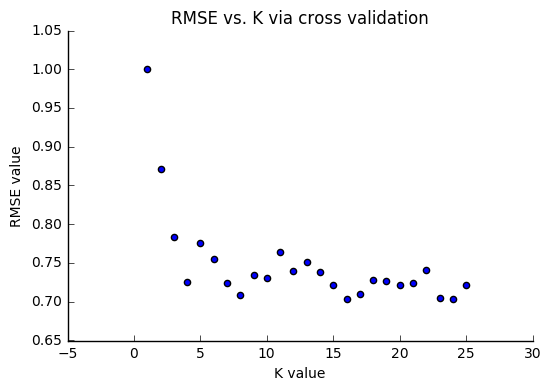

In [42]:
# find the best K, create a plot

plt.scatter(range(1, K + 1), rmses)
plt.xlabel("K value")
plt.ylabel("RMSE value")
plt.title("RMSE vs. K via cross validation")

ax = plt.subplot()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


The best choice for K is 4. The graph starts high and has a steep decrease at K = 4. When the graph is at its lowest point, that means it has the lowest RMSE value, meaning this is the point with the least amount of error in the test dataset. After K = 4, the graph continues to fluctuate until it looks like it's evening out towards the end as the K values increase.

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather
arbitrary. For extra credit, implement a basic (See Hastie,
Tibshirani, Friedman _Elements of statistical Learning_, Ch 3.3)
algorithm to progressively include features that decrease the
cross-validated RMSE of the model. Note that the optimal value of K
may be different for each model, so you may want to use
cross-validation to choose K each time (but it is also fine if you fix
K at the optimal value from 2.7).  Create a graph that shows RMSE as a
function of the number of features in the model. Label each point on
the x-axis with the name of the feature that is added at that step in
the forward selection algorithm.  For instance, if the optimal
single-feature model has CRIM with RMSE = 10, and the optimal
two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will
say CRIM and the second x-axis lable with say ZN